#**Proyecto Final Elements of Machine Learning: Clasificación de imágenes para detectar Neumonía**##

En este proyecto final se evaluará el modelo de Redes Neuronales para poder clasificar e identificar imágenes de rayos-x de personas que tienen neumonía y personas que no tienen.

## **Conceptos Clave** ##

***GPU:*** La Unidad de Procesamiento Gráfico, o Graphics Processing Unit, es un procesador especial que acelera la capacidad reproducción de las imágenes.

***Kernel:*** Matriz que se "pone" sobre una imagen para obtener un output basado en operaciones y pesos deseados.

***Convolution:*** Método para extraer características de las imágenes usando kernels.

***Tensorflow:*** Es una librería que se enfoca en el entrenamiento de modelos de Deep Learning.

***Keras:*** Una interfase de programación que sirve para reducir la carga cognitiva de los datos que va a trabajar. Ayuda a reducir las acciones requeridas para los modelos.

***Conv2D:*** Una capa que crea un Convolution Kernel para producir outputs con la información de las imágenes.

***MaxPooling2D:*** Minimiza el input de datos a menores dimensiones (altura y ancho).

***Dropout:*** Los Dropouts eliminan inputs de las capas. Esto nos ayuda a que podamos evitar Overfitting ya que al hacer esto eliminamos partes para que el modelo no se "aprenda" los datos y pueda evaluar correctamente.

***Epochs:*** Los Epochs representan la cantidad de veces que pasamos el Traindata por el modelo hacia adelante y hacia atrás. 1 Epoch nos dice que pasaremos toda la data una vez por el modelo de "ida y vuelta". Los Epochs están formados por batches de información, entonces si hay "x" cantidad de datos, se dividirán entre el número de Epochs y pasarán por el modelo. Mientras más Epochs se usen más se entrenará el modelo y mejor podrá predecir.

## **Metodología** ##

Para llevar a cabo el modelo, primero se cargarán las imágenes (las cuales no serán tantas porque el modelo no logra correr si son muchas) dividiéndolas en Test Set, Validation Test y Train Test, luego se sacará una muestra de las mismas para observar cómo se ven las fotos. Luego crearemos una Red Neuronal que será testeada con el Training Set y el Validation Set. Paso siguiente, modificaremos la Red Neuronal para poder evaluar que no haya Overfitting y al encontrar y evaluar estos cambios, se procederá a evaluar el proyecto con el Test set para evaluar el modelo creado.

## Carga de Librerías ##

In [1]:
# Librerías normales #
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Librerías relacionadas con las Redes Neuronales #
import tensorflow as tf
print(tf.__version__)
import keras
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import TensorBoard 
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split

%matplotlib inline

#Librerías EfficientNet03
from keras import applications
from tensorflow.keras.applications import EfficientNetB3

2.4.1


In [2]:
# En primer lugar verificamos que sí estemos usando un GPU para que corra más rápido el script. #
# (Usamos COLAB ya que la computadora no tenía la capacidad para correr el código usando el CPU normal) #
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Observamos los devices que se tienen disponibles #
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9473309375707271067, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5989904619301373195
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
# Con esta función podemos "traer" los datos que subimos a drive para poder usarlos #
# (Se necesita hacer login en la cuenta para acceder a todos los datos, pero estos se pueden #
# enviar si se desean) #
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
# Definimos las dos categorías en las que se dividirán los pulmones. #
classes = ['normal','pneumonia']

In [6]:
# Primero creamos una instancia que pueda escalar las imágenes escaladas y en un formato de 300 X 300 #
# La distribución de la data está en entreno, testeo y validación y está distribuída en 70%, 15% y 15% respectivamente. #
# Habían únicamente 60 datos en la carpeta de validación, por lo que se trasladaron algunas imágenes de train #
# a la carpeta de val apra poder tener nuestros datos de validación y de test. #

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


traindata = image_generator.flow_from_directory("/content/gdrive/My Drive/xray_pulmones/train",
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 500)
testdata = image_generator.flow_from_directory('/content/gdrive/My Drive/xray_pulmones/test',
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 75)
valdata = image_generator.flow_from_directory('/content/gdrive/My Drive/xray_pulmones/val',
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 75)

Found 1620 images belonging to 2 classes.
Found 493 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


In [7]:
# Con esta función creada buscamos visualizar algunas imágenes #
# para observar cómo se "trajeron" las fotos #

def imagenes_vusializacion(batch_imagen, batch_nombre):
  plt.figure(figsize=(15,15))
  for n in range(20):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch_imagen[n])
      plt.title(classes[int(np.where(batch_nombre[n] == 1)[0])].title())
      plt.axis('off')

(300, 300, 3)


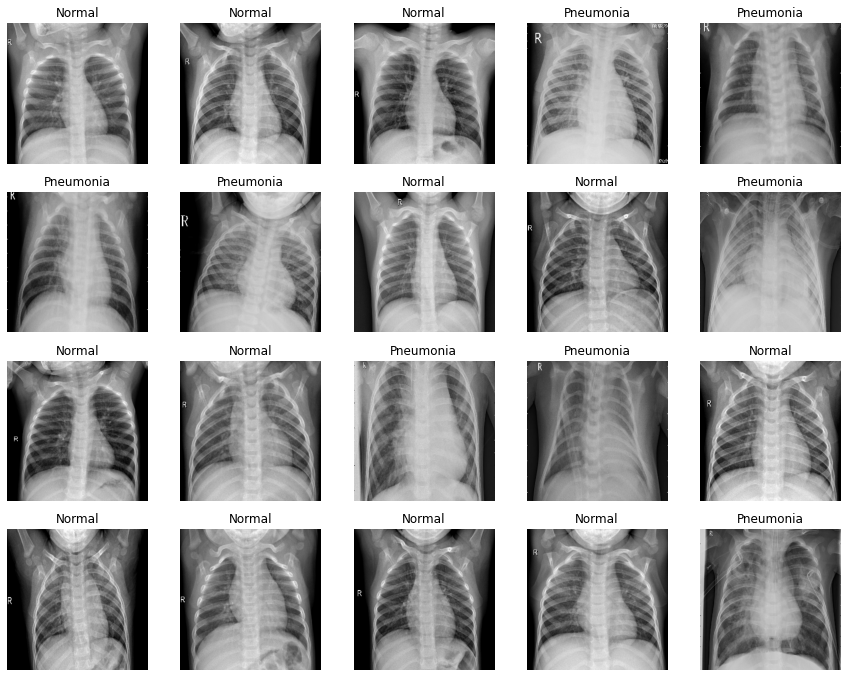

In [8]:
batch_imagen, batch_nombre = next(traindata)
imagenes_vusializacion(batch_imagen, batch_nombre)

(print(batch_imagen.shape[1:]))

In [9]:
# Resumiremos la cantidad de fotos y el shape que tienen estas mismas #
for batch_imagen, batch_nombre in traindata:
    print(batch_imagen.shape)
    print(batch_nombre.shape)
    break

(500, 300, 300, 3)
(500, 2)


In [10]:
# Ahora creamos la Red Neuronal, con 3 layers (incluyendo un drop después de cada uno para evitar el overfitting) #
# y definimos el Dropout con 20% para que se eliminen algunas conecciones entre las capas #

## Primera Capa ##
modelo = Sequential()
modelo.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))
## Segunda Capa ##
modelo.add(Conv2D(32, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
## Segunda Capa ##
modelo.add(Conv2D(64, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## Dense ##
modelo.add(Flatten())
modelo.add(Dense(128, activation = 'relu'))
modelo.add(Dense(2, activation = 'softmax'))

## Finalmente compilamos el modelo entero ##
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
# Finalmente vemos cómo queda el modelo antes de poder utilizarlo #
print(modelo.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 64)        0

In [12]:
# probamos el modelo usando pocos epochs ya que no sabemos si la computadora podrá procesarlo #
# Los epochs nos ayudan a tomar 
resultado_entreno = modelo.fit(traindata, epochs = 2, validation_data = valdata, shuffle = True, verbose = 2)

Epoch 1/2
4/4 - 288s - loss: 3.2181 - accuracy: 0.5222 - val_loss: 1.0917 - val_accuracy: 0.5000
Epoch 2/2
4/4 - 28s - loss: 0.8144 - accuracy: 0.4981 - val_loss: 0.6800 - val_accuracy: 0.5000


In [13]:
# Ahora probaremos usar 10 epochs para observar cómo funciona el modelo #
resultado_entreno = modelo.fit(traindata, epochs = 10, validation_data = valdata, shuffle = True, verbose = 2)

Epoch 1/10
4/4 - 29s - loss: 0.6577 - accuracy: 0.6327 - val_loss: 0.6104 - val_accuracy: 0.7970
Epoch 2/10
4/4 - 28s - loss: 0.5661 - accuracy: 0.8148 - val_loss: 0.4768 - val_accuracy: 0.8879
Epoch 3/10
4/4 - 28s - loss: 0.4285 - accuracy: 0.8623 - val_loss: 0.3162 - val_accuracy: 0.9061
Epoch 4/10
4/4 - 28s - loss: 0.3551 - accuracy: 0.8660 - val_loss: 0.2651 - val_accuracy: 0.9030
Epoch 5/10
4/4 - 28s - loss: 0.2814 - accuracy: 0.8802 - val_loss: 0.1964 - val_accuracy: 0.9364
Epoch 6/10
4/4 - 28s - loss: 0.2246 - accuracy: 0.9111 - val_loss: 0.1600 - val_accuracy: 0.9364
Epoch 7/10
4/4 - 27s - loss: 0.1896 - accuracy: 0.9253 - val_loss: 0.1068 - val_accuracy: 0.9697
Epoch 8/10
4/4 - 27s - loss: 0.1474 - accuracy: 0.9494 - val_loss: 0.0920 - val_accuracy: 0.9727
Epoch 9/10
4/4 - 28s - loss: 0.1279 - accuracy: 0.9531 - val_loss: 0.0752 - val_accuracy: 0.9848
Epoch 10/10
4/4 - 28s - loss: 0.1071 - accuracy: 0.9636 - val_loss: 0.0658 - val_accuracy: 0.9848


Logramos observar que el proyecto logra llegar a tener un accuracy bueno mientras vamos avanzando, el modelo va aprendiendo y se va a adaptando. Pero para evitar y corroborar que no haya overfitting cambiaremos un poco la manera en la que la red está creada para añadirle más dropouts y además eliminaremos una capa. A continuación realizaremos el modelo y probaremos si funciona mejor que los anteriores.

In [14]:
# Ahora modificaremos la Red Neuronal, aumentando la cantidad de neuronas en cada capas y eliminaremos una capa #
# y agregamos los dropouts y los definimos 20% para que se eliminen algunas conecciones entre las capas #

## Primera Capa ##
modelo = Sequential()
modelo.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.20))
## Segunda Capa ##
modelo.add(Conv2D(32, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## Dense ##
modelo.add(Flatten())
modelo.add(Dense(128, activation = 'relu'))
modelo.add(Dense(2, activation = 'softmax'))

## Finalmente compilamos el modelo entero ##
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
print(modelo.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 170528)           

In [16]:
# probamos el modelo usando pocos epochs ya que no sabemos si la computadora podrá procesarlo #
resultado_entreno3 = modelo.fit(traindata, epochs = 2, validation_data = valdata, shuffle = True, verbose = 2)

Epoch 1/2
4/4 - 30s - loss: 5.5890 - accuracy: 0.5198 - val_loss: 3.6195 - val_accuracy: 0.5000
Epoch 2/2
4/4 - 27s - loss: 7.5064 - accuracy: 0.4753 - val_loss: 0.7401 - val_accuracy: 0.5000


In [17]:
# Ahora probaremos usar 10 epochs para observar cómo funciona el modelo #
resultado_entreno4 = modelo.fit(traindata, epochs = 10, validation_data = valdata, shuffle = True, verbose = 2)

Epoch 1/10
4/4 - 29s - loss: 1.1208 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
4/4 - 27s - loss: 0.6896 - accuracy: 0.5247 - val_loss: 0.6875 - val_accuracy: 0.6576
Epoch 3/10
4/4 - 27s - loss: 0.6855 - accuracy: 0.5247 - val_loss: 0.6816 - val_accuracy: 0.6788
Epoch 4/10
4/4 - 27s - loss: 0.6831 - accuracy: 0.5284 - val_loss: 0.6741 - val_accuracy: 0.6394
Epoch 5/10
4/4 - 28s - loss: 0.6650 - accuracy: 0.7265 - val_loss: 0.6584 - val_accuracy: 0.7788
Epoch 6/10
4/4 - 28s - loss: 0.6274 - accuracy: 0.7679 - val_loss: 0.6166 - val_accuracy: 0.6909
Epoch 7/10
4/4 - 28s - loss: 0.5657 - accuracy: 0.8123 - val_loss: 0.5556 - val_accuracy: 0.6788
Epoch 8/10
4/4 - 27s - loss: 0.4988 - accuracy: 0.8228 - val_loss: 0.4499 - val_accuracy: 0.9242
Epoch 9/10
4/4 - 28s - loss: 0.3995 - accuracy: 0.8728 - val_loss: 0.3826 - val_accuracy: 0.8939
Epoch 10/10
4/4 - 29s - loss: 0.3349 - accuracy: 0.8877 - val_loss: 0.3164 - val_accuracy: 0.8970


Podemos observar que tenemos valores similares de precisión (97% y 88%) por lo que asumimos que no tenemos un caso de overfitting, pero el dropout ayudó a que se lograra evitar esto. Por este motivo continuaremos utilizando la red con las 3 capas para evaluar el modelo, incluyendo los dropouts.

In [18]:
# Usamos el modelo completo para evaluar el moodelo #

## Primera Capa ##
modelo = Sequential()
modelo.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.20))
## Segunda Capa ##
modelo.add(Conv2D(32, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## tercera Capa ##
modelo.add(Conv2D(64, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## Dense ##
modelo.add(Flatten())
modelo.add(Dense(128, activation = 'relu'))
modelo.add(Dense(2, activation = 'softmax'))

## Finalmente compilamos el modelo entero ##
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
print(modelo.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)       

In [20]:
# Probamos el modelo usando pocos epochs ya que no sabemos si la computadora podrá procesarlo #
resultado_entreno5 = modelo.fit(traindata, epochs = 2, validation_data = testdata, shuffle = True, verbose = 2)

Epoch 1/2
4/4 - 143s - loss: 7.5851 - accuracy: 0.5068 - val_loss: 1.8703 - val_accuracy: 0.3347
Epoch 2/2
4/4 - 31s - loss: 2.0152 - accuracy: 0.5049 - val_loss: 0.6347 - val_accuracy: 0.6653


In [21]:
# Ahora probaremos usar 15 epochs para observar cómo funciona el modelo #
resultado_entreno6 = modelo.fit(traindata, epochs = 10, validation_data = testdata, shuffle = True, verbose = 2)

Epoch 1/10
4/4 - 31s - loss: 0.8250 - accuracy: 0.4753 - val_loss: 0.6809 - val_accuracy: 0.6653
Epoch 2/10
4/4 - 30s - loss: 0.6914 - accuracy: 0.4759 - val_loss: 0.6869 - val_accuracy: 0.8479
Epoch 3/10
4/4 - 30s - loss: 0.6834 - accuracy: 0.6031 - val_loss: 0.6905 - val_accuracy: 0.4706
Epoch 4/10
4/4 - 30s - loss: 0.6695 - accuracy: 0.5710 - val_loss: 0.6745 - val_accuracy: 0.8073
Epoch 5/10
4/4 - 30s - loss: 0.6144 - accuracy: 0.7185 - val_loss: 0.6242 - val_accuracy: 0.8824
Epoch 6/10
4/4 - 29s - loss: 0.5417 - accuracy: 0.7593 - val_loss: 0.5130 - val_accuracy: 0.8905
Epoch 7/10
4/4 - 30s - loss: 0.4218 - accuracy: 0.8093 - val_loss: 0.4382 - val_accuracy: 0.8803
Epoch 8/10
4/4 - 30s - loss: 0.3644 - accuracy: 0.8463 - val_loss: 0.4139 - val_accuracy: 0.8499
Epoch 9/10
4/4 - 30s - loss: 0.2862 - accuracy: 0.8833 - val_loss: 0.3873 - val_accuracy: 0.8337
Epoch 10/10
4/4 - 30s - loss: 0.2439 - accuracy: 0.8969 - val_loss: 0.3124 - val_accuracy: 0.8884


# **Modelo EfficientNet** #

Probaremos el método de EfficientNet, el cual usa la arquitectura de las Redes Neuronales, para obtener una "familia de modelos" (hay EficcientNet desde 0 a 7). Incluso, el EfficientNet-B7 logra tener una precisión del 84.3% para el tratamiento de las imágenes, siendo, este modelo, más pequeño y logrando mejores resultados que las Redes Neuronales Convolucionales. 

Se creará un ejemplo de un modelo usando EfficientNet para comparar si este tipo de modelaje da mejores resultados que las Redes Neuronales. Se usa la versión de EfficientNet-B3 ya que, según cierta documentación, la versión se usa dependiendo del tamaño de la imagen y este es el que se usa para 

Se dejarán las referencias que hablan de estos modelos como uno de los modelos State-of-the-Art y su información.

***Información del modelo y su artículo:*** https://arxiv.org/abs/1905.11946v1

***Perfil de la librerías en Keras:*** https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

***Información del modelo como parte de State-of-the-Art:*** https://towardsdatascience.com/overview-state-of-the-art-machine-learning-algorithms-per-discipline-per-task-c1a16a66b8bb

Se intentó realizar el código en la misma sesión pero no hubo suficiente memoria para el modelo pudiera realizarse, por lo que se llevó a cabo en otro notebook que será subido al GIT por aparte. Pero para intentar comparar ambos modelos, se vovlerán a cargar los datos en este notebook con las mismas medidas que se usarán en el otro modelo (el motivo se explica en dicho notebook).

In [22]:
# Para la comparar ambos modelos se cambiará el tamaño de las imágenes #
# al mismo que se usa en el modelo de EffectiveNet#

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


traindata2 = image_generator.flow_from_directory("/content/gdrive/My Drive/xray_pulmones/train",
                                           target_size = (50, 50),
                                           class_mode = 'categorical',
                                           batch_size = 500)
testdata2 = image_generator.flow_from_directory('/content/gdrive/My Drive/xray_pulmones/test',
                                           target_size = (50, 50),
                                           class_mode = 'categorical',
                                           batch_size = 75)
valdata2 = image_generator.flow_from_directory('/content/gdrive/My Drive/xray_pulmones/val',
                                           target_size = (50, 50),
                                           class_mode = 'categorical',
                                           batch_size = 75)

Found 1620 images belonging to 2 classes.
Found 493 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


In [23]:
# Usamos el modelo completo para evaluar el moodelo #

## Primera Capa ##
modelo = Sequential()
modelo.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (50, 50, 3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.20))
## Segunda Capa ##
modelo.add(Conv2D(32, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## tercera Capa ##
modelo.add(Conv2D(64, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## Dense ##
modelo.add(Flatten())
modelo.add(Dense(128, activation = 'relu'))
modelo.add(Dense(2, activation = 'softmax'))

## Finalmente compilamos el modelo entero ##
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# Ahora probaremos usar 10 epochs para observar cómo funciona el modelo #
resultado_entreno7 = modelo.fit(traindata2, epochs = 10, validation_data = testdata2, shuffle = True, verbose = 2)

Epoch 1/10
4/4 - 28s - loss: 0.6967 - accuracy: 0.5333 - val_loss: 0.6656 - val_accuracy: 0.6653
Epoch 2/10
4/4 - 26s - loss: 0.6711 - accuracy: 0.5735 - val_loss: 0.6995 - val_accuracy: 0.3347
Epoch 3/10
4/4 - 26s - loss: 0.6454 - accuracy: 0.5981 - val_loss: 0.6317 - val_accuracy: 0.8742
Epoch 4/10
4/4 - 26s - loss: 0.5852 - accuracy: 0.7809 - val_loss: 0.5609 - val_accuracy: 0.8803
Epoch 5/10
4/4 - 26s - loss: 0.5065 - accuracy: 0.7840 - val_loss: 0.5622 - val_accuracy: 0.8093
Epoch 6/10
4/4 - 26s - loss: 0.4652 - accuracy: 0.7895 - val_loss: 0.5698 - val_accuracy: 0.6856
Epoch 7/10
4/4 - 26s - loss: 0.4235 - accuracy: 0.8142 - val_loss: 0.5991 - val_accuracy: 0.5923
Epoch 8/10
4/4 - 26s - loss: 0.3905 - accuracy: 0.8327 - val_loss: 0.4505 - val_accuracy: 0.8418
Epoch 9/10
4/4 - 27s - loss: 0.3278 - accuracy: 0.8722 - val_loss: 0.3622 - val_accuracy: 0.8844
Epoch 10/10
4/4 - 26s - loss: 0.3151 - accuracy: 0.8765 - val_loss: 0.3646 - val_accuracy: 0.8925


# **Comparación de EffectiveNet y las RNC** #

Al observar el desempeño de este modelo y el modelo de EffectiveNet, usando los parámetros iguales en relación con el número de Epochs y el tamaño de la imagen, podemos observar que el desempeño de EffectiveNet es superior a este (ojo, este no es un mal modelo, ya que aún con un tamaño significativamente menor puede clasificar las imágenes con un 87% de effectividad).

El modelo de State-of-the-Art demuestra ser superior, así como se leyó y se investigó, y puede clasificar de manera excelsa las imágenes e incluso podría hacerlo sin la necesidad de usar tantos Epochs. Por estas razones se considera que el método de EffectiveNet es el que clasifica mejor.